<a href="https://colab.research.google.com/github/PX2145-2025/week-8-b-cormack-bethan/blob/main/odes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feedback from previous weeks and other and hints

1. Be careful about your environment remembering variables. Make sure your code works in a new _clean_ environment. In Colab: `Runtime`->`restart Runtime`, in Anaconda's Jupyter: `Kernel`->`Restart`.
2. Keep the file names when saving to GitHub. It's always possible to go back to a previous version, you are not losing anything.
3. Run all the cells before saving to GitHub so the output is saved.
4. Graphs without labels (or units when appropriate) are not worth any point.
5. Do put in sufficient explanatory comments in your code.

For this week you can use these imports at the start of your programs:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# Introduction

In this worksheet we examine how to solve Ordinary Differential Equations (ODEs) using Python. ODEs are of course central to the study of physics as nearly all our descriptions of nature are formulated, and solved, using ODEs of some sort.

In PX1224 you studied how to solve differential equations using the simple Euler method and the Euler-Cromer method. Revise week 9 and 10 from last year and re-run your code to make sure you understand it. This week introduces you to a powerful method to solve ODEs which is faster and more robust than Euler or Euler-Cromer methods, and is capable of handling more complicated differential equations.

## The scipy library and odeint

The `scipy` library for Python includes many functions for scientific computing and data analysis. The function `odeint` will let us solve numerically one or more _first order_ ODEs using various sophisticated algorithms. It is used to find a solution $y(t)$ to a differential equation:

```python
y = scipy.integrate.odeint(func, y0, t)
```

where `t` is the sequence of time points for which to solve for $y(t)$, and `y` is the returned solution array of the same length. `y0` is the initial value of `y`, and `func` is the name of a function which defines the derivative of `y`.

The full description is available in the online [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html), but let's start with a simple example. Take the ODE:

$$
\frac{dy}{dt} = - \lambda y
$$

which has the analytic solution $y = y_0 \exp(−\lambda t)$ as verified by substitution. It describes radioactive decay for example, where $y(t)$ represents the number of undecayed nuclei at a time t.

Let's first set things up, with, say, $y_0=1000$:

In [ ]:
npts = 1000 # Number of points
tmax = 10 # Maximum time

# setting up the time array:
t = np.linspace(0.0, tmax, npts)

# And the initial conditions:
t[0] = 0.0
y0 = 1e3

So, in this case using the `odeint()` function would look like this:

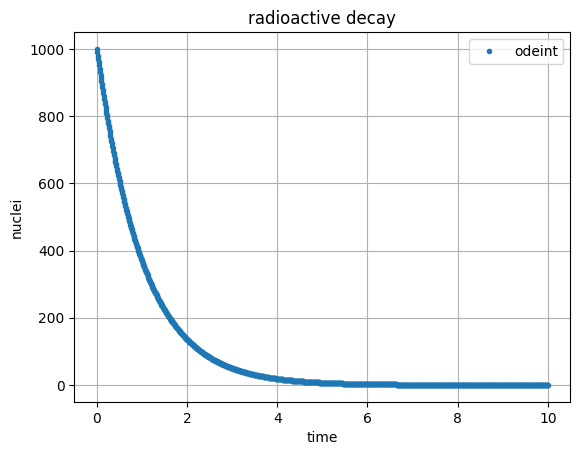

In [ ]:
lam = 1.0
def f(y, t): # return derivative(s) of the array y
    return -lam*y

y_odeint = odeint(f, y0, t)

plt.plot(t, y_odeint,'.',label='odeint')
plt.xlabel('time')
plt.ylabel('nuclei')
plt.title('radioactive decay')
plt.legend()
plt.grid()

Let's compare this solution obtained with `odeint()` with the analytical solution:

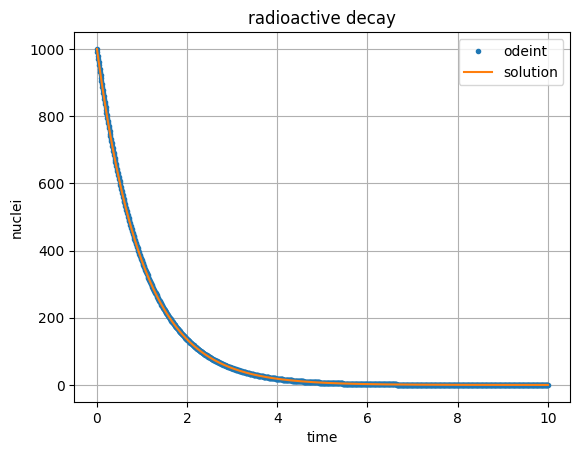

In [ ]:
def solution(t): # return the analytic solution
    return y0*np.exp(-lam*t)

plt.plot(t, y_odeint,'.',label='odeint')
plt.plot(t, solution(t),label='solution')
plt.xlabel('time')
plt.ylabel('nuclei')
plt.title('radioactive decay')
plt.legend()
plt.grid()

We can also compare this methods to the Euler method that you used last year:

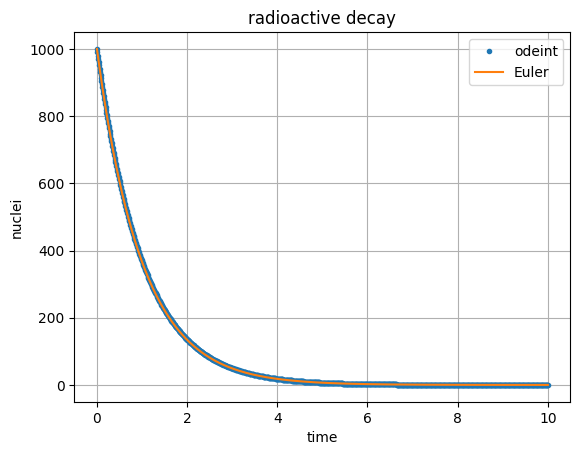

In [ ]:
# use Euler's method to integrate equation for radioactive decay
# y_euler is the array for the solution y:
y_euler = np.zeros_like(t)
y_euler[0] = y0

dt = tmax/npts
for i in range(npts -1):
    y_euler[i+1] = y_euler[i] - lam*y_euler[i]*dt

plt.plot(t, y_odeint,'.',label='odeint')
plt.plot(t, y_euler, label='Euler')
plt.xlabel('time')
plt.ylabel('nuclei')
plt.title('radioactive decay')
plt.legend()
plt.grid()

## Improving the function definition

In order to be able to use a different value of $\lambda$ without modifying the function itself each time (that would be a very bad idea) you should modify the function definition and the way it is called like this:

In [ ]:
npts = 1000 # Number of points
tmax = 10 # Maximum time

# setting up the time array:
t = np.linspace(0.0, tmax, npts)

def f(y, t, lam): # return derivative(s) of the array y
    return -lam*y

yinit = 1e3 # initial value
y_odeint = odeint(f, yinit, t, args=(2.0,))

The extra argument to the function needs to be passed to odeint as a “tuple” of values, i.e. a series of values in brackets separated by commas. So $\lambda$ is equal to 2.0 in this example.

## Solving several ODEs at once

The real power of `odeint` lies in the fact that it can solve several ODEs all at once, which can be coupled equations. Since we can transform a second order ODE into two coupled first order ODEs, you can immediately see why this is so useful.

Take the example of the ODE describing the displacement $y$ of a mass on a spring:

$$
m\frac{d^2y}{dt^2} = -ky
$$

Defining $y' = dy/dt$ (which is the velocity of the mass) we can re-write this second order ODE as the two first order ODEs:

$$
\begin{aligned}
\frac{dy}{dt} &= y' \\
\frac{dy'}{dt} &= -\frac{k}{m}y
\end{aligned}
$$

In order to work with these two derivatives, `odeint` needs them as elements of an array, so that `y` is a 2D array:

$$
\begin{aligned}
\frac{dy[0]}{dt} &= y[1] \\
\frac{dy[1]}{dt} &= -\frac{k}{m}y[0]
\end{aligned}
$$

$y[0]$ contains all the "zeroth" derivative as a function of time, and $y[1]$ the first derivatives. We modify the code defining the function and the way that `odeint` is used accordingly:

In [ ]:
def f(y, t): # return derivatives of the array y
    k = 10.0
    m = 1.0
    return [ y[1], # the first equation dy[0]/dt
            -(k/m)*y[0] # the second equation dy[1]/dt
           ]

yinit = [0.1, 0] # TWO initial values, y and y'
y = odeint(f, yinit , t)

And y is indeed a 2D array, with the zeroth derivatives in the first column, and the first derivatives in the second column:

In [ ]:
print(y)

[[ 0.1         0.        ]
 [ 0.0999499  -0.01000832]
 [ 0.09979967 -0.02000663]
 ...
 [ 0.09897162 -0.0452358 ]
 [ 0.09846931 -0.05511855]
 [ 0.09786833 -0.06494608]]


# Exercises


This must be marked before you leave the lab. Mark weighting is in brackets. **Save your work to GitHub after having run all cells with `Runtime` -> `Restart and run all`. And do not change the notebook's filename.**. Do add comments to your code, you'll lose points if your code is hard to understand. Graphs without labels (or units when appropriate) are not worth any point.

## Exercise 0

[0] Using the radioactive decay differential equation from the start of the worksheet, measure with `curve_fit()` the decay constant $\lambda$ from the (noisy) measurements of Oxygen-22 nuclei as a function of time from the file [ex0.txt](https://raw.githubusercontent.com/PX2134/data/master/week8/ex0.txt). The starting number of nuclei was `y0=100`.

(this exercise is for demonstration purposes and won't be marked)

**Note**: this is similar to question 4 of exercise 2...


since runall imports everything at start of doc no imports

In [ ]:
# Read in time [s] and number of nuclei from the data file ex0.txt
t_data, N_data = np.loadtxt("/ex0.txt", unpack=True)

# Starting number of nuclei
y0 = 100.0

print("Loaded", len(t_data), "data points for Oxygen-22 decay.")


Loaded 50 data points for Oxygen-22 decay.


In [ ]:
# Define the analytical decay model and use curve_fit to find the decay constant.

def decay_model(t, lam):
    """Radioactive decay law N(t) = y0 * exp(-lam * t)."""
    return y0 * np.exp(-lam * t)

# Rough starting guess for the decay constant (per second)
lam_guess = 0.5

# Fit the model to the noisy data
popt, pcov = curve_fit(decay_model, t_data, N_data, p0=[lam_guess])

lam_fit = popt[0]
lam_err = np.sqrt(pcov[0, 0])

# Work out the half-life from the fitted decay constant
t_half = np.log(2.0) / lam_fit

print("Fitted decay constant lambda =", lam_fit, "+/-", lam_err, "s^-1")
print("Corresponding half-life t_1/2 =", t_half, "s")


Fitted decay constant lambda = 0.3051850696928741 +/- 0.012531047537848176 s^-1
Corresponding half-life t_1/2 = 2.2712355530940633 s


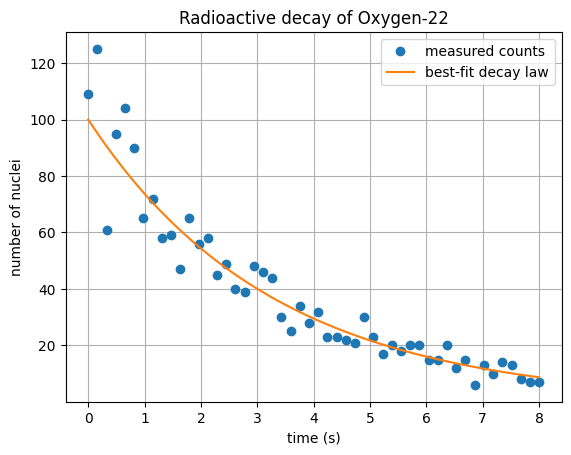

In [ ]:
# Plot the data points and the best-fitting exponential decay curve.

# Smooth time array for the fitted curve
t_fit = np.linspace(t_data.min(), t_data.max(), 500)

plt.figure()
plt.plot(t_data, N_data, "o", label="measured counts")
plt.plot(t_fit, decay_model(t_fit, lam_fit), "-", label="best-fit decay law")

plt.xlabel("time (s)")
plt.ylabel("number of nuclei")
plt.title("Radioactive decay of Oxygen-22")
plt.legend()
plt.grid(True);


## Exercise 1

 (1). [2] Using the last Python snippet as a guide, solve the ODE for a mass on a spring and plot the result for a suitable range of time.

In [ ]:
# Parameters for the mass–spring system
k = 10.0   # spring constant
m = 1.0    # mass

# Natural angular frequency and period
omega = np.sqrt(k / m)
T = 2.0 * np.pi / omega

# Time array: a few oscillation periods
t = np.linspace(0.0, 5.0 * T, 1000)

def f(y, t):
    """
    Mass on a spring written as a first–order system.

    y[0] = displacement y(t)
    y[1] = velocity dy/dt
    """
    return [y[1],              # dy/dt = velocity
            -(k / m) * y[0]]   # d^2y/dt^2 = - (k/m) * y

# Initial conditions: small displacement, zero initial velocity
y_init = [0.1, 0.0]

# Solve the ODE system with odeint
y_sol = odeint(f, y_init, t)

# Extract displacement and velocity for convenience
y_pos = y_sol[:, 0]
y_vel = y_sol[:, 1]


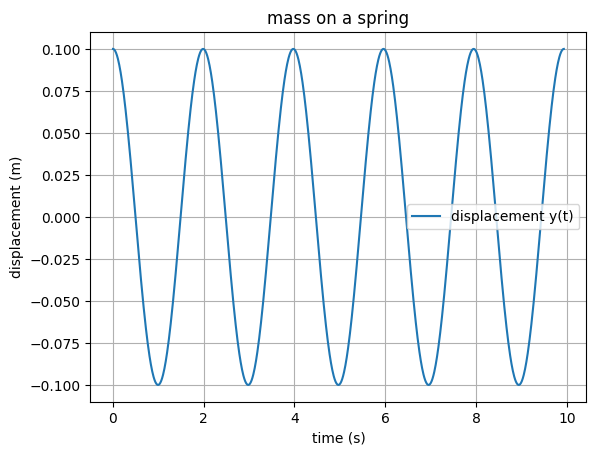

In [ ]:
# Plot the displacement as a function of time for the mass on a spring.

plt.figure()
plt.plot(t, y_pos, label="displacement y(t)")

plt.xlabel("time (s)")
plt.ylabel("displacement (m)")
plt.title("mass on a spring")
plt.grid(True)
plt.legend();


 (2). [3] Modify your code so that the derivatives function accepts the parameters $k$ and $m$ instead of defining them within the function. Plot the results.

In [ ]:
# Same mass-spring parameters
k = 10.0   # spring constant
m = 1.0    # mass

# Natural angular frequency and period
omega = np.sqrt(k / m)
T = 2.0 * np.pi / omega

# Time array over a few periods
t = np.linspace(0.0, 5.0 * T, 1000)

def f_param(y, t, k, m):
    """
    Mass on a spring written as a first-order system, with k and m
    supplied as parameters.

    y[0] = displacement y(t)
    y[1] = velocity dy/dt
    """
    return [y[1],              # dy/dt = velocity
            -(k / m) * y[0]]   # d^2y/dt^2 = - (k/m) * y

# Initial conditions: small displacement, zero initial velocity
y_init = [0.1, 0.0]

# Solve the ODE system with odeint, passing k and m through args
y_sol_param = odeint(f_param, y_init, t, args=(k, m))

# Extract displacement and velocity
y_pos_param = y_sol_param[:, 0]
y_vel_param = y_sol_param[:, 1]


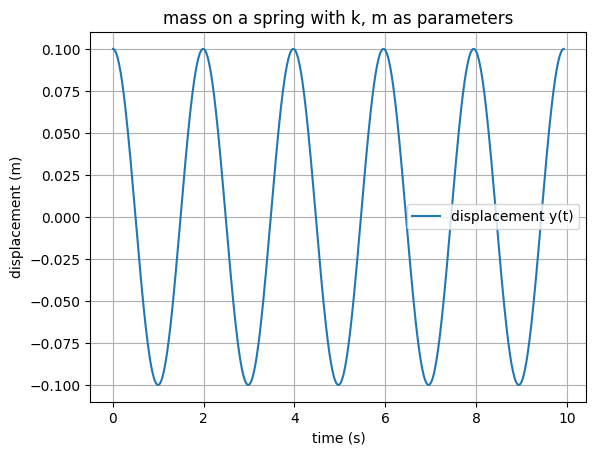

In [ ]:
# Plot the displacement as a function of time for the parameterised mass-spring system.

plt.figure()
plt.plot(t, y_pos_param, label="displacement y(t)")

plt.xlabel("time (s)")
plt.ylabel("displacement (m)")
plt.title("mass on a spring with k, m as parameters")
plt.grid(True)
plt.legend();


 (3). [3] Finally, modify your code, with the above improvements to the function, to solve for the damped mass on a spring:

$$
\begin{aligned}
\frac{dy}{dt} &= y' \\
\frac{dy'}{dt} &= -\frac{k}{m}y -\frac{b}{m}\frac{dy}{dt}
\end{aligned}
$$

Modify your derivatives function to accept the damping parameter $b$ in addition to the parameter $k$ and $m$. Plot the results for $b=0.5$.


In [ ]:
# Parameters
k = 10.0    # spring constant
m = 1.0     # mass
b = 0.5     # damping coefficient

# Use the same basic time range - a few oscillation periods
omega = np.sqrt(k / m)
T = 2.0 * np.pi / omega
t = np.linspace(0.0, 5.0 * T, 1000)

def f_damped(y, t, k, m, b):
    """
    Damped mass on a spring written as a first-order system.

    y[0] = displacement y(t)
    y[1] = velocity dy/dt
    """
    dy_dt = y[1]
    dv_dt = -(k / m) * y[0] - (b / m) * y[1]
    return [dy_dt, dv_dt]

# Initial conditions: small displacement, zero initial velocity
y_init = [0.1, 0.0]

# Solve the ODE system with odeint, passing k, m, b as parameters
y_sol_damped = odeint(f_damped, y_init, t, args=(k, m, b))

# Extract displacement and velocity
y_pos_damped = y_sol_damped[:, 0]
y_vel_damped = y_sol_damped[:, 1]


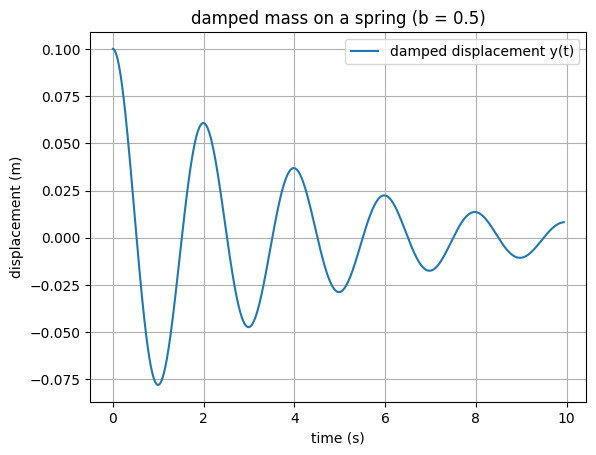

In [ ]:
# Plot the displacement as a function of time for the damped mass-spring system.

plt.figure()
plt.plot(t, y_pos_damped, label="damped displacement y(t)")

plt.xlabel("time (s)")
plt.ylabel("displacement (m)")
plt.title("damped mass on a spring (b = 0.5)")
plt.grid(True)
plt.legend();


(4). [5] For the next question, you are trying to measure the spring constant $k$ and the damping parameter $b$ of a spring. You attach a known mass $m$ of 1.0 kg to the spring, move it `y0=0.5` meters from rest, release it at zero speed, and use a detector to measure its displacement as a function of time. Unfortunately this is a measurement done inside a nuclear reactor and there's a lot of noise on the detector... Your measurement is saved in the file [spring_measurement.txt](https://raw.githubusercontent.com/PX2134/data/master/week8/spring_measurement.txt).

- plot this file, the position of the mass at the end of the spring as a function of time

We will use `curve_fit()` to fit this data, the documentation is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). As a quick summary: `curve_fit()` takes 3 mandatory arguments (the function to fit `func`, the data `x_data` to apply this function to, and the data `y_data` the fitting function will be tweaked to fit), e.g.:
```python
popt,pcov = curve_fit(func,x_data,y_data)
```
The return values are the list of best fit values `popt` and the corresponding covariance matrix `pcov`. The fitting function `func()` **must** have a specific signature: it must take the independent variable as the first argument and the parameters to fit as separate remaining arguments. For instance, it must be possible to have:
```python
y_predicted = func(x_data,some,guess,parameters)
```
And in that case, `y_predicted` would be compared to `y_data` by `curve_fit` to assess wether `[some,guess,parameters]` is a good fit for `y_data`.
`curve_fit` also accepts optional parameters, such as an initial guess `p0` (a list of parameters) for the initial fit parameters. You should always try to plot `y_initial_guess=func(x_data,*p0)`, the prediction of `func` with the inital guess, agains the data `y_data`.

- define a function which takes as input an array of time, and two parameters $k$ and $b$. It should call `odeint()` to solve the damped spring ODE with a fixed mass of 1kg, and return the array of positions corresponding to the array of time for that spring. You will need to define in the function the initial position, initial speed, and the mass. Use the function you defined above.

- call that function with some initial guess $k$ and $b$, and plot that prediction agains the data from `spring_measurement.txt`

- run `curve_fit` with the function you created and give your estimates for the spring constant and damping parameter of the spring. Make a plot if you want to check your answer.

Loaded 500 measurement points for the damped spring.


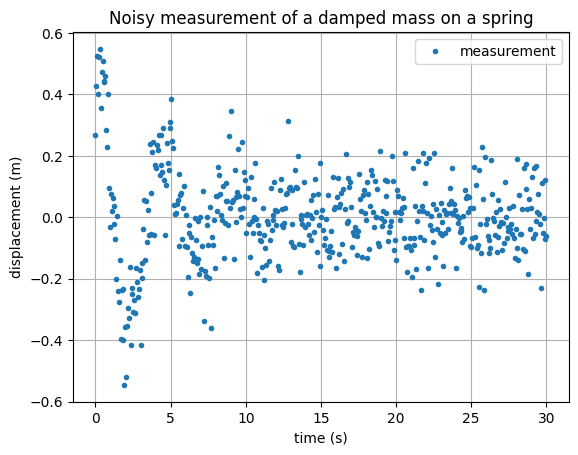

In [ ]:
# Read time [s] and measured displacement [m] from the data file.
t_meas, y_meas = np.loadtxt("/spring_measurement.txt", unpack=True)

print("Loaded", len(t_meas), "measurement points for the damped spring.")

# Quick plot of the raw data
plt.figure()
plt.plot(t_meas, y_meas, "o", markersize=3, label="measurement")
plt.xlabel("time (s)")
plt.ylabel("displacement (m)")
plt.title("Noisy measurement of a damped mass on a spring")
plt.grid(True)
plt.legend();


In [ ]:
# Func - solve the damped spring ODE with fixed initial conditions and return displacement.

def spring_model(t, k, b):
    m = 1.0          # mass in kg
    y0 = 0.5         # initial displacement in m
    v0 = 0.0         # initial speed in m/s
    y_init = [y0, v0]

    # Use the damped derivatives function from part (3)
    y_sol = odeint(f_damped, y_init, t, args=(k, m, b))
    return y_sol[:, 0]   # return only the displacement


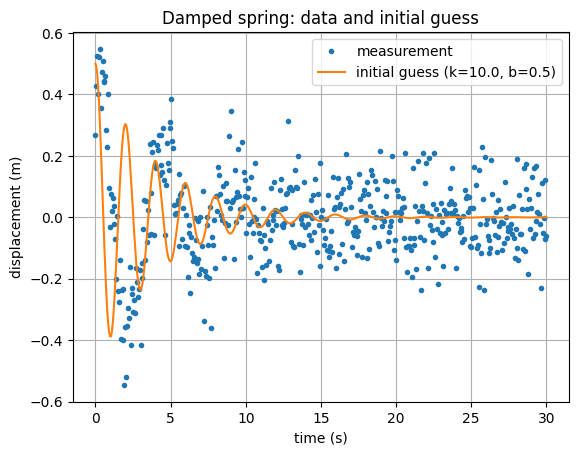

In [ ]:
# Try guess for k and b and compare to the data.

k_guess = 10.0
b_guess = 0.5

y_guess = spring_model(t_meas, k_guess, b_guess)

plt.figure()
plt.plot(t_meas, y_meas, "o", markersize=3, label="measurement")
plt.plot(t_meas, y_guess, "-", label=f"initial guess (k={k_guess}, b={b_guess})")
plt.xlabel("time (s)")
plt.ylabel("displacement (m)")
plt.title("Damped spring: data and initial guess")
plt.grid(True)
plt.legend();


Best-fit spring constant k = 9.730275040327513 +/- 0.10394646599358857
Best-fit damping parameter b = 0.5189451264717436 +/- 0.005225519271023398


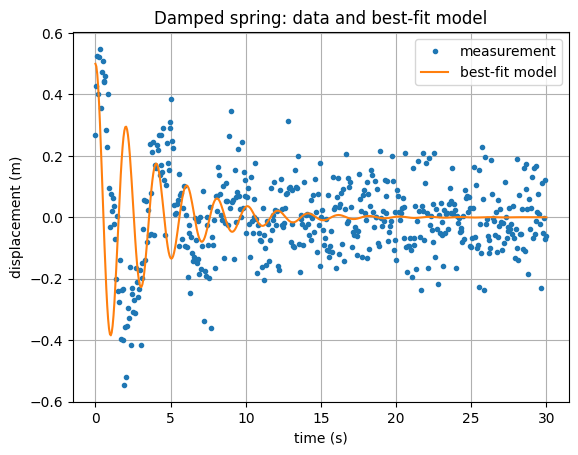

In [ ]:
# Use curve_fit to estimate k and b from noisy data.

p0 = [k_guess, b_guess]          # initial guess for [k, b]
popt, pcov = curve_fit(spring_model, t_meas, y_meas, p0=p0)

k_fit, b_fit = popt
k_err, b_err = np.sqrt(np.diag(pcov))

print("Best-fit spring constant k =", k_fit, "+/-", k_err)
print("Best-fit damping parameter b =", b_fit, "+/-", b_err)

# Predicted displacement using the best-fit parameters
y_fit = spring_model(t_meas, k_fit, b_fit)

plt.figure()
plt.plot(t_meas, y_meas, "o", markersize=3, label="measurement")
plt.plot(t_meas, y_fit, "-", label="best-fit model")
plt.xlabel("time (s)")
plt.ylabel("displacement (m)")
plt.title("Damped spring: data and best-fit model")
plt.grid(True)
plt.legend();


## Exercise 2

[7] The driven van der Pol oscillator obeys the ODE:

$$
\frac{d^2y}{dt^2} - m(1 - y^2) \frac{dy}{dt} + y - A \sin(\omega t) = 0
$$

It is an example of a non-linear oscillator and can show mathematically chaotic behaviour.

Write the equation as two coupled first order ODEs and calculate its behaviour.

Plot graphs of $y$ versus $t$ and $y'$ versus $y$. The latter plot is called a "phase space plot" or "phase portrait".
(**Hint**: pick starting parameter values of $m = 8$, $A = 1$ and $\omega = 0.6$ and vary them to get interesting plots. You will need to pick a suitable range of time.)

In [ ]:
# Parameters
m = 8.0      # non-linearity / damping parameter
A = 1.0      # driving amplitude
omega = 0.6  # driving angular frequency

# Time array - fairly long run to actually see stuff
t_max = 200.0
n_points = 5000
t = np.linspace(0.0, t_max, n_points)

def vdp_derivs(y, t, m, A, omega):
    """
    Driven van der Pol oscillator written as first-order system.

    y[0] = y(t)
    y[1] = y'(t)
    """
    y_val = y[0]
    v_val = y[1]

    dy_dt = v_val
    dv_dt = m * (1.0 - y_val**2) * v_val - y_val + A * np.sin(omega * t)

    return [dy_dt, dv_dt]

# Initial conditions: position and velocity
y0 = [0.1, 0.0]

# Solve the ODE system
y_sol = odeint(vdp_derivs, y0, t, args=(m, A, omega))

# Extract y and y'
y_vals = y_sol[:, 0]
v_vals = y_sol[:, 1]


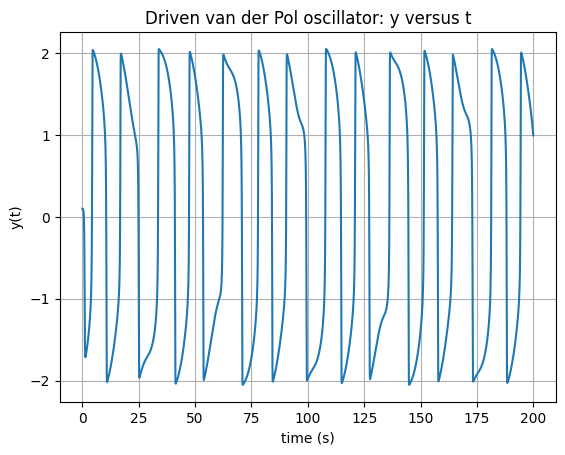

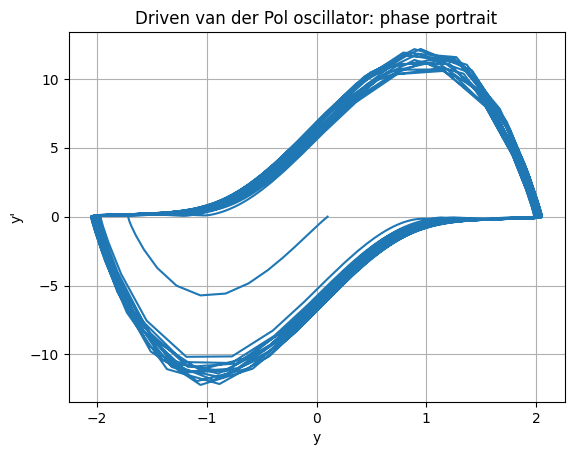

In [ ]:
# Plot y(t) over time

plt.figure()
plt.plot(t, y_vals)
plt.xlabel("time (s)")
plt.ylabel("y(t)")
plt.title("Driven van der Pol oscillator: y versus t")
plt.grid(True);

# Phase space plot: y' versus y

plt.figure()
plt.plot(y_vals, v_vals)
plt.xlabel("y")
plt.ylabel("y'")
plt.title("Driven van der Pol oscillator: phase portrait")
plt.grid(True);


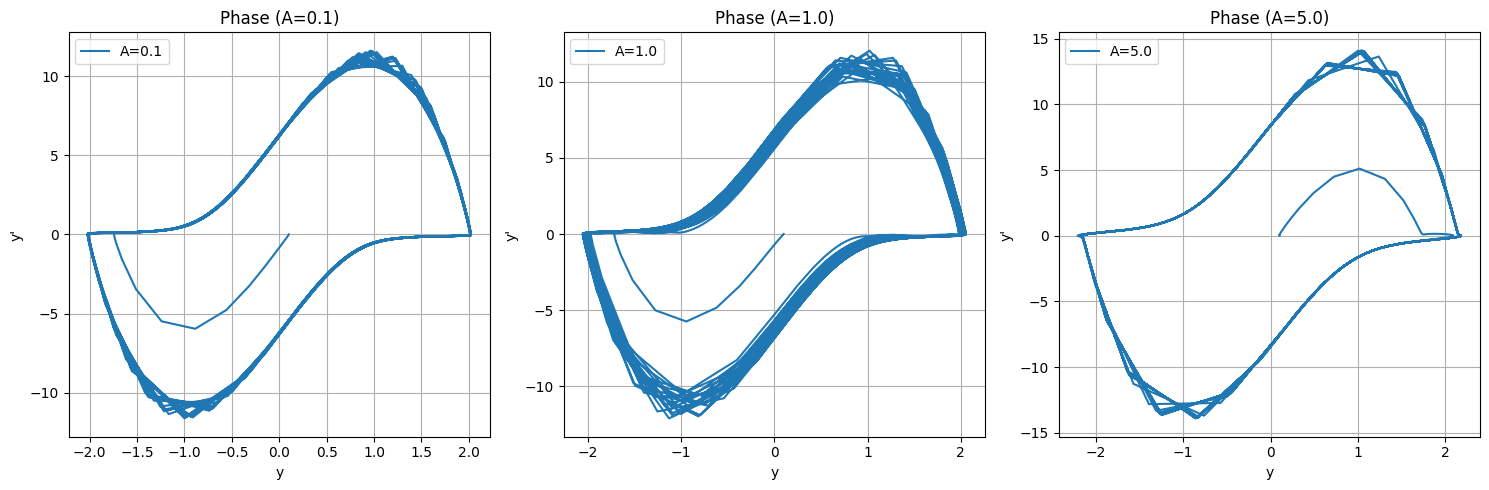

In [ ]:
# Different amplitudes

def vdp_derivs(y, t, m, A, omega):
    """
    Driven van der Pol oscillator written as first-order system.

    y[0] = y(t)
    y[1] = y'(t)
    """
    y_val = y[0]
    v_val = y[1]

    dy_dt = v_val
    dv_dt = m * (1.0 - y_val**2) * v_val - y_val + A * np.sin(omega * t)

    return [dy_dt, dv_dt]

# Fixed parameters
m_fixed = 8.0
omega_fixed = 0.6

# Different driving amplitudes to test
A_values = [0.1, 1.0, 5.0]

# Time array
t_max = 300.0
n_points = 5000
t = np.linspace(0.0, t_max, n_points)

# Initial conditions
y0 = [0.1, 0.0]

plt.figure(figsize=(15, 5))

for i, A_val in enumerate(A_values):
    # Solve the ODE system for each A_val
    y_sol = odeint(vdp_derivs, y0, t, args=(m_fixed, A_val, omega_fixed))

    # Extract y and y'
    y_vals = y_sol[:, 0]
    v_vals = y_sol[:, 1]

    # Plot phase space
    plt.subplot(1, len(A_values), i + 1)
    plt.plot(y_vals, v_vals, label=f'A={A_val}')
    plt.xlabel("y")
    plt.ylabel("y'")
    plt.title(f"Phase (A={A_val})")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()
